#  adversarial training using custom loss


In [1466]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1467]:
import os
from os.path import join

import time 
import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import gc


from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import Loss,CategoricalCrossentropy

import copy

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report


from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

In [1468]:
tf.config.run_functions_eagerly(False)

In [1469]:
tf.random.set_seed(0)

#### 1. Load Data

In [1470]:
data_mnist=datasets.mnist.load_data(path='mnist.npz')
X_train_mnist,y_train_mnist=data_mnist[0][0],data_mnist[0][1]
X_test_mnist,y_test_mnist=data_mnist[1][0],data_mnist[1][1]
y_train= to_categorical(y_train_mnist, 10)
y_test= to_categorical(y_test_mnist, 10)

""" Train """
X_train_img_mnist = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train_mnist):
    X_train_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
    
    
""" Test """
X_test_img_mnist = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test_mnist):
    X_test_img_mnist[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB)
    
X_train=X_train_img_mnist
X_test= X_test_img_mnist

In [1471]:
data_set=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=100000).batch(32)

#### 2. Load models

On défini une classe qui créé des modèles dont la fonction objectif est une combinaison de deux fonction objectifs. La première est une cross-entropie classique et la seconde est une cross-entropie adverse. C'est à dire une fonction qui vise à correctement classifier un exemple adverse 

$$J_{tot}(\theta,x,y)=(1-c)J(\theta,x,y)+cJ(\theta,(x+{\epsilon}sign(\nabla_{x}J(\theta,x,y)),y)$$ 

Pour cela nous avons du réécrire la fonction d'entrainement du modèle afin d'entrainer la bonne fonction objectif

In [1472]:
class Model(tf.keras.Model):
    def __init__(self,c,learning_rate,epsilon):
        super(Model,self).__init__()
        
        self.c=c
        self.learning_rate=learning_rate
        self.epsilon=epsilon
        
        self.model = tf.keras.models.Sequential()
        self.model.add(Conv2D(64, (3, 3), activation='relu',input_shape=(32,32,3)))
        self.model.add(MaxPooling2D(2, 2))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(10, activation='softmax'))

        self.loss = CategoricalCrossentropy()
        self.optimizer = tf.keras.optimizers.SGD(self.learning_rate)        
        
   
    @tf.function
    def train_step(self,x,y):

        with tf.GradientTape() as tape_w:  
            
            with tf.GradientTape() as tape_x:
                tape_x.watch(x)
                true_loss = self.loss(y, self.model(x))        
            gradient = tape_x.gradient(true_loss, x)       
            signed_grad = tf.sign(gradient)      
            adv_loss= self.loss(y, self.model(x+self.epsilon*signed_grad))    
       
      # Combines both losses            
            total_loss= (1-self.c)*true_loss + self.c*adv_loss
            
    # Regular backward pass.
            gradients = tape_w.gradient(total_loss, self.model.trainable_variables)        
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            
       
    def train(self,train_dataset, x_test,y_test,epochs):

        pred=list(map(np.argmax,self.model.predict(x_test)))
        true_values=list(map(np.argmax,y_test))
        acc=np.sum([1 for i in range(len(pred)) if pred[i]==true_values[i]])/len(pred)         
        print('Accuracy before training is {} '.format(acc))
        print('-----------')

        for epoch in range(epochs):
            if epoch==8:
                self.epsilon*=10
            start = time.time()
            for (x,y) in tqdm(train_dataset,position=0):
                x=tf.cast(x,dtype='float32')           
                self.train_step(x,y)           

            pred=list(map(np.argmax,self.model.predict(x_test)))
            true_values=list(map(np.argmax,y_test))
            acc=np.sum([1 for i in range(len(pred)) if pred[i]==true_values[i]])/len(pred)         

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            print('-----------')
            print('Accuracy for epoch {} is {} '.format(epoch + 1, acc))        
            
       
    def call(self, inputs):
        x = self.model(inputs)
        return x


In [1473]:
models_dict={}
for c in [0,0.1,0.3,0.5,0.7,0.9]:
    print("======= c: "+str(c)+'======')
    models_dict[c]=Model(c=c,learning_rate=0.001,epsilon=5)
    models_dict[c].train(data_set, X_test[:1000],y_test[:1000], 5)
    

  0%|          | 0/1875 [00:00<?, ?it/s]

======= c: 0======
Accuracy before training is 0.098 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.836750745773315 sec
-----------
Accuracy for epoch 1 is 0.972 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.329196691513062 sec
-----------
Accuracy for epoch 2 is 0.981 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.35031008720398 sec
-----------
Accuracy for epoch 3 is 0.978 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.375419616699219 sec
-----------
Accuracy for epoch 4 is 0.982 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.365091562271118 sec
-----------
Accuracy for epoch 5 is 0.981 
======= c: 0.1======
Accuracy before training is 0.064 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.869258880615234 sec
-----------
Accuracy for epoch 1 is 0.971 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.410709857940674 sec
-----------
Accuracy for epoch 2 is 0.974 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.479096412658691 sec
-----------
Accuracy for epoch 3 is 0.978 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.488240718841553 sec
-----------
Accuracy for epoch 4 is 0.982 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.47447943687439 sec
-----------
Accuracy for epoch 5 is 0.98 
======= c: 0.3======
Accuracy before training is 0.08 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.905088186264038 sec
-----------
Accuracy for epoch 1 is 0.956 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.424080610275269 sec
-----------
Accuracy for epoch 2 is 0.971 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.448788166046143 sec
-----------
Accuracy for epoch 3 is 0.973 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.473142623901367 sec
-----------
Accuracy for epoch 4 is 0.972 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.481966972351074 sec
-----------
Accuracy for epoch 5 is 0.973 
======= c: 0.5======
Accuracy before training is 0.114 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.820703506469727 sec
-----------
Accuracy for epoch 1 is 0.958 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.455692529678345 sec
-----------
Accuracy for epoch 2 is 0.97 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.547555685043335 sec
-----------
Accuracy for epoch 3 is 0.977 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.488147735595703 sec
-----------
Accuracy for epoch 4 is 0.975 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.480196714401245 sec
-----------
Accuracy for epoch 5 is 0.977 
======= c: 0.7======
Accuracy before training is 0.118 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.90442156791687 sec
-----------
Accuracy for epoch 1 is 0.957 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.422698974609375 sec
-----------
Accuracy for epoch 2 is 0.966 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.437317132949829 sec
-----------
Accuracy for epoch 3 is 0.972 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.499547958374023 sec
-----------
Accuracy for epoch 4 is 0.966 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 5 is 9.532270908355713 sec
-----------
Accuracy for epoch 5 is 0.98 
======= c: 0.9======
Accuracy before training is 0.12 
-----------


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 1 is 9.907028436660767 sec
-----------
Accuracy for epoch 1 is 0.838 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 2 is 9.446699142456055 sec
-----------
Accuracy for epoch 2 is 0.953 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 3 is 9.484287023544312 sec
-----------
Accuracy for epoch 3 is 0.972 


  0%|          | 0/1875 [00:00<?, ?it/s]

Time for epoch 4 is 9.459224700927734 sec
-----------
Accuracy for epoch 4 is 0.975 


100%|██████████| 1875/1875 [00:09<00:00, 200.29it/s]


Time for epoch 5 is 9.457271099090576 sec
-----------
Accuracy for epoch 5 is 0.974 


In [1474]:
def DOC (x_adv_list,x_list):
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

Test de la resistance du modèle 

In [1475]:
def attack_performances_computer(model_to_attack,predicting_model,attack, image_list, labels,epsilon):
    model_to_attack=TensorFlowModel(model_to_attack , bounds=(0, 255))
   
    success_on_attacked_model=[]
    success_on_predicting_model=[]
    adv_list=[]
    for i,image in enumerate(tqdm(image_list,position=0)):
        image = np.asarray(image)[:
                                  ,:,:3].astype('float32')
        image = convert_to_tensor(np.expand_dims(image,axis=0))
        label=labels[i]
        label = tf.convert_to_tensor(np.array([label]))
        _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=[epsilon])
        success_on_attacked_model.append(bool(is_adv[0]))
        adv_list.append(np.array(clipped[0]))
        prediction=predicting_model.predict(np.expand_dims(clipped[0][0],axis=0))
        if np.argmax(prediction)!=labels[i]:
            success_on_predicting_model.append(True)
        else:
            success_on_predicting_model.append(False)
            
        
    DOC_attack=DOC(adv_list,image_list)
    SR_on_attacked_model=succes_rate(success_on_attacked_model)
    SR_on_predicting_model=succes_rate(success_on_predicting_model)
    return(DOC_attack,SR_on_attacked_model,SR_on_predicting_model)


In [1476]:
def attack_runner(model_to_attack,predicting_model,image_list, labels_list, epislons_list):   
    labels_list=list(map(np.argmax,labels_list))
    
    attack_FGSM=LinfFastGradientAttack()
    
   

    SR_FGSM_dic={}  
    SR_FGSM_dic_with_defense={}


    for epsilon in epislons_list:
        print('======'+'epislon: '+str(epsilon)+'======')
        DOC_FGSM,SR_FGSM,SR_FGSM_with_defense=attack_performances_computer(model_to_attack,predicting_model,attack_FGSM, image_list, labels_list,epsilon)
              
        SR_FGSM_dic[DOC_FGSM]=SR_FGSM
        SR_FGSM_dic_with_defense[DOC_FGSM]=SR_FGSM_with_defense
        
    return(SR_FGSM_dic,SR_FGSM_dic_with_defense)

In [1477]:
plots={}
epsilons=[0.1,0.5,1,5,7,10,15,20,30,50]
X=X_test[7000:7100]
y=y_test[7000:7100]
for c,model in models_dict.items():
    print("======= c: "+str(c)+'======')
    plots[c],_=attack_runner(model,model,X, y, epsilons)
    

  0%|          | 0/100 [00:00<?, ?it/s]

======= c: 0======
======epislon: 0.1======


  3%|▎         | 3/100 [00:00<00:03, 26.23it/s]

======epislon: 0.5======


  3%|▎         | 3/100 [00:00<00:03, 26.14it/s]

======epislon: 1======


  3%|▎         | 3/100 [00:00<00:03, 28.54it/s]

======epislon: 5======


  3%|▎         | 3/100 [00:00<00:03, 29.29it/s]

======epislon: 7======


  3%|▎         | 3/100 [00:00<00:03, 29.79it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 30.00it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 29.78it/s]

======epislon: 20======


  3%|▎         | 3/100 [00:00<00:03, 29.99it/s]

======epislon: 30======


  3%|▎         | 3/100 [00:00<00:03, 28.21it/s]

======epislon: 50======


  2%|▏         | 2/100 [00:00<00:04, 19.93it/s]

======= c: 0.1======
======epislon: 0.1======


  3%|▎         | 3/100 [00:00<00:03, 28.16it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:03, 30.54it/s]

======epislon: 1======


  4%|▍         | 4/100 [00:00<00:03, 30.71it/s]

======epislon: 5======


  3%|▎         | 3/100 [00:00<00:03, 28.23it/s]

======epislon: 7======


  3%|▎         | 3/100 [00:00<00:03, 27.34it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 29.31it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 29.44it/s]

======epislon: 20======


  3%|▎         | 3/100 [00:00<00:03, 29.57it/s]

======epislon: 30======


  3%|▎         | 3/100 [00:00<00:03, 29.68it/s]

======epislon: 50======


  2%|▏         | 2/100 [00:00<00:04, 19.60it/s]

======= c: 0.3======
======epislon: 0.1======


  3%|▎         | 3/100 [00:00<00:03, 29.30it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:02, 32.14it/s]

======epislon: 1======


  4%|▍         | 4/100 [00:00<00:02, 32.02it/s]

======epislon: 5======


  4%|▍         | 4/100 [00:00<00:02, 32.25it/s]

======epislon: 7======


  4%|▍         | 4/100 [00:00<00:02, 32.05it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 29.73it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 26.70it/s]

======epislon: 20======


  3%|▎         | 3/100 [00:00<00:03, 29.96it/s]

======epislon: 30======


  3%|▎         | 3/100 [00:00<00:03, 29.85it/s]

======epislon: 50======


  3%|▎         | 3/100 [00:00<00:03, 25.17it/s]

======= c: 0.5======
======epislon: 0.1======


  4%|▍         | 4/100 [00:00<00:02, 32.45it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:02, 32.29it/s]

======epislon: 1======


  4%|▍         | 4/100 [00:00<00:02, 32.51it/s]

======epislon: 5======


  4%|▍         | 4/100 [00:00<00:03, 30.95it/s]

======epislon: 7======


  4%|▍         | 4/100 [00:00<00:03, 31.13it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 28.37it/s]

======epislon: 15======


  4%|▍         | 4/100 [00:00<00:03, 31.07it/s]

======epislon: 20======


  3%|▎         | 3/100 [00:00<00:03, 28.74it/s]

======epislon: 30======


  4%|▍         | 4/100 [00:00<00:02, 32.25it/s]

======epislon: 50======


  3%|▎         | 3/100 [00:00<00:04, 23.94it/s]

======= c: 0.7======
======epislon: 0.1======


  4%|▍         | 4/100 [00:00<00:02, 32.31it/s]

======epislon: 0.5======


  4%|▍         | 4/100 [00:00<00:03, 30.94it/s]

======epislon: 1======


  4%|▍         | 4/100 [00:00<00:03, 30.59it/s]

======epislon: 5======


  4%|▍         | 4/100 [00:00<00:03, 31.05it/s]

======epislon: 7======


  4%|▍         | 4/100 [00:00<00:03, 31.01it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 25.36it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 25.75it/s]

======epislon: 20======


  3%|▎         | 3/100 [00:00<00:03, 26.12it/s]

======epislon: 30======


  3%|▎         | 3/100 [00:00<00:03, 28.75it/s]

======epislon: 50======


  2%|▏         | 2/100 [00:00<00:05, 19.47it/s]

======= c: 0.9======
======epislon: 0.1======


  3%|▎         | 3/100 [00:00<00:03, 28.72it/s]

======epislon: 0.5======


  3%|▎         | 3/100 [00:00<00:03, 28.73it/s]

======epislon: 1======


  3%|▎         | 3/100 [00:00<00:03, 29.15it/s]

======epislon: 5======


  3%|▎         | 3/100 [00:00<00:03, 29.40it/s]

======epislon: 7======


  3%|▎         | 3/100 [00:00<00:03, 26.58it/s]

======epislon: 10======


  3%|▎         | 3/100 [00:00<00:03, 26.62it/s]

======epislon: 15======


  3%|▎         | 3/100 [00:00<00:03, 26.42it/s]

======epislon: 20======


  3%|▎         | 3/100 [00:00<00:03, 29.70it/s]

======epislon: 30======


  3%|▎         | 3/100 [00:00<00:03, 27.86it/s]

======epislon: 50======


100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


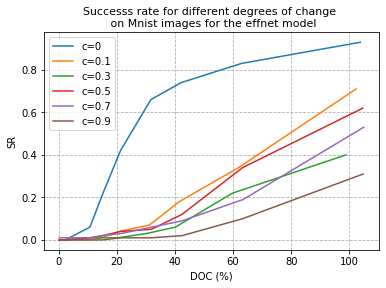

In [1478]:
for c,plot in plots.items():
    plt.plot(list(plot.keys()),list(plot.values()),label='c='+str(c))
plt.grid(True,which="both", linestyle='--')
plt.title('Successs rate for different degrees of change \n on Mnist images for the effnet model',fontsize=11)
plt.xlabel('DOC (%)')
plt.ylabel('SR')
plt.legend(loc='upper left')

Clearly the adversarial training has decreased the efficiency of the attacks so it is truly beneficial. It seems that the higher c is and the better the protection

### Visualizations

In [1503]:

model_to_attack=TensorFlowModel(model_naif , bounds=(0, 255))
attack=LinfFastGradientAttack()
image_list=X_test[:100]
labels=list(map(np.argmax,y_test[:100]))
adv_list=[]
true_label=[]
for i,image in enumerate(tqdm(image_list,position=0)):
    image = np.asarray(image)[:,:,:3].astype('float32')
    image = convert_to_tensor(np.expand_dims(image,axis=0))
    label=labels[i]
    label = tf.convert_to_tensor(np.array([label]))
    _, clipped, is_adv = attack(model_to_attack,image,label,epsilons=50)
    if bool(is_adv[0])==True:
        adv_list.append(np.array(clipped[0]))
        true_label.append(labels[i])
    






100%|██████████| 100/100 [00:00<00:00, 172.45it/s]


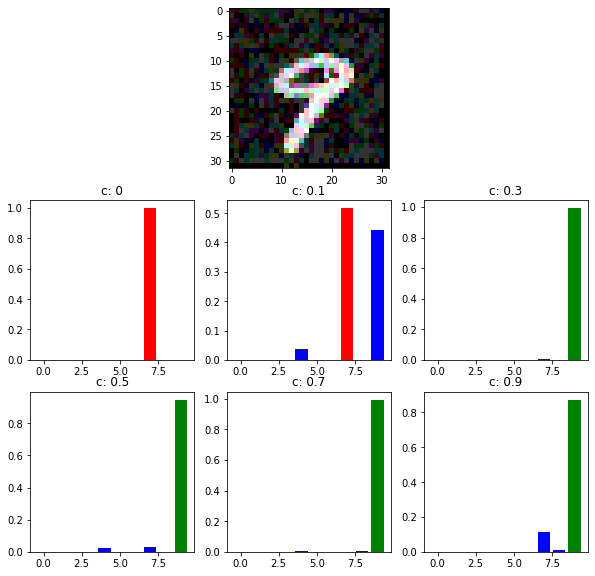

In [1504]:
adv_image_num=9


plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]): 
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=models_dict[c].predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))


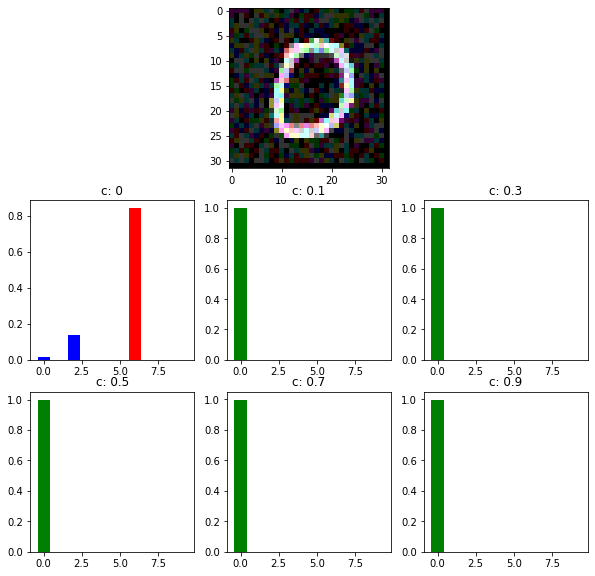

In [1505]:
adv_image_num=10


plt.figure(figsize=(10,10))
ax = plt.subplot(3, 3, 2)
plt.imshow(adv_list[adv_image_num].astype('int32'))
for i,c in enumerate([0,0.1,0.3,0.5,0.7,0.9]): 
    ax = plt.subplot(3, 3, 3+i + 1)
    color=['blue' for i in range(10)]
    prediction=models_dict[c].predict(np.expand_dims(adv_list[adv_image_num],axis=0))[0]
    if np.argmax(prediction)==true_label[adv_image_num]:
        color[true_label[adv_image_num]]='green'
    else:
        color[np.argmax(prediction)]='red'
    plt.bar(x=[i for i in range(10)], height=prediction,color=color)
    plt.title('c: '+str(c))